# Script Set Up

In [ ]:
%matplotlib inline

In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 38.7 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns
import mne
import statistics

In [ ]:
!pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 558.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=bdc56cdf13c6c6a97208493bc5b72bba3a218a0b844e3e02770470472595883f
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [ ]:
import pingouin as pg

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load Behaviour
Metadata (dataframes) with no trials rejected

In [ ]:
ID_list = ['P1', 'P3', 'P4', 'P7', 'P10', 'P12', 'P15', 'P17', 'P19', 'P21', 'P22', 'P23', 'P24',
           'P26', 'P27', 'P28', 'P29', 'P30']

group_behaviour_encode = []
group_behaviour_repo = []
group_behaviour_RL = []

for ID in ID_list:
  fname = "/content/gdrive/MyDrive/Time_Reproduction/Metadata/" + ID + "_Encoding_Metadata_All.csv"
  df = pd.read_csv(fname,  index_col = 0)
  df["ID"] = ID # adding ID column
  temp_cols=df.columns.tolist()
  new_cols=temp_cols[-1:] + temp_cols[:-1]
  df=df[new_cols]
  group_behaviour_encode.append(df)

  fname = "/content/gdrive/MyDrive/Time_Reproduction/Metadata/" + ID + "_Repo_Metadata_All.csv"
  df = pd.read_csv(fname,  index_col = 0)
  group_behaviour_repo.append(df)

  fname = "/content/gdrive/MyDrive/Time_Reproduction/Metadata/" + ID + "_RL_Metadata_All.csv"
  df = pd.read_csv(fname,  index_col = 0)
  group_behaviour_RL.append(df)

group_behaviour_df = pd.concat(group_behaviour_encode, ignore_index = True)
print(group_behaviour_df.shape)

group_behaviour_repo_df = pd.concat(group_behaviour_repo, ignore_index = True)
print(group_behaviour_repo_df.shape)

group_behaviour_RL_df = pd.concat(group_behaviour_RL, ignore_index = True)
print(group_behaviour_RL_df.shape)

(15289, 10)
(15289, 9)
(15289, 9)


In [ ]:
group_behaviour_df.head()

,ID,Response_Time,Over_Under,Mean_RT,Median_RT,Trigger,Gap,Reject_Artif,RT_gap,Reject_All
0,P1,851.562500,0.0,1026.308594,1013.867188,56,431.640625,0.0,1283.203125,0.0
1,P1,865.234375,0.0,997.128906,981.640625,53,402.343750,0.0,1267.578125,1.0
2,P1,861.328125,0.0,1035.390625,1028.515625,57,406.250000,1.0,1267.578125,1.0
3,P1,861.328125,0.0,1038.046875,1029.492188,58,373.046875,0.0,1234.375000,1.0
4,P1,914.062500,0.0,1013.515625,1011.914062,55,437.500000,0.0,1351.562500,0.0


# Removing Outlier RTs
Removing RTs < 150ms abd RTs > 1500ms

In [ ]:
print(group_behaviour_df.shape[0])
group_behaviour_df_outliers = group_behaviour_df.query("Response_Time < 150").index
print(group_behaviour_df_outliers)
group_behaviour_df_outliers = list(group_behaviour_df_outliers)
print(group_behaviour_df_outliers)
print(len(group_behaviour_df_outliers))
group_behaviour_df_outliers += list(group_behaviour_df.query("Response_Time > 1500").index)
group_behaviour_df = group_behaviour_df.drop(group_behaviour_df_outliers)
print(group_behaviour_df.shape[0])

15289
Int64Index([14071], dtype='int64')
[14071]
1
15135


# Subtracting 50ms from response times

In [ ]:
copy_df = group_behaviour_df.copy()
print(group_behaviour_df["Response_Time"].mean())
group_behaviour_df["Response_Time"] = group_behaviour_df["Response_Time"] - 50
print(group_behaviour_df["Response_Time"].mean())

906.8610371242154
856.8610371242154


# Relabel the Trigger Column

In [ ]:
replace_dict = {51: 600, 52: 650, 53: 700, 54: 750, 55: 800, 56: 850, 57: 900, 58: 950, 59: 1000}
group_behaviour_df["Trigger"].replace(replace_dict, inplace = True)

group_behaviour_df.rename(columns = {"Trigger": "SI"}, inplace = True)

copy_df["Trigger"].replace(replace_dict, inplace = True)
copy_df.rename(columns = {"Trigger": "SI"}, inplace = True)

In [ ]:
group_behaviour_df

,ID,Response_Time,Over_Under,Mean_RT,Median_RT,SI,Gap,Reject_Artif,RT_gap,Reject_All
0,P1,801.562500,0.0,1026.308594,1013.867188,850,431.640625,0.0,1283.203125,0.0
1,P1,815.234375,0.0,997.128906,981.640625,700,402.343750,0.0,1267.578125,1.0
2,P1,811.328125,0.0,1035.390625,1028.515625,900,406.250000,1.0,1267.578125,1.0
3,P1,811.328125,0.0,1038.046875,1029.492188,950,373.046875,0.0,1234.375000,1.0
4,P1,864.062500,0.0,1013.515625,1011.914062,800,437.500000,0.0,1351.562500,0.0
...,...,...,...,...,...,...,...,...,...,...
15284,P30,1147.265625,1.0,1159.707031,1137.890625,1000,402.343750,0.0,1599.609375,0.0
15285,P30,873.828125,1.0,884.492188,860.546875,600,443.359375,0.0,1367.187500,0.0
15286,P30,862.109375,1.0,892.343750,874.218750,650,355.468750,0.0,1267.578125,0.0
15287,P30,1057.421875,1.0,1109.980469,1095.898438,950,443.359375,0.0,1550.781250,0.0


# Relationship between sample interval and RT

## Get conditions
Within participant, get mean or median RT for each sample interval

In [ ]:
SIs = np.unique(group_behaviour_df["SI"])
n_bins = len(SIs)
mean_RTs = pd.DataFrame({"ID": list("0") * (len(ID_list) * n_bins),
                         "SI": np.zeros(len(ID_list) * n_bins),
                          "Mean_RT": np.zeros(len(ID_list) * n_bins),
                          "Median_RT": np.zeros(len(ID_list) * n_bins)})

i  = -1

for ID in ID_list:
  participant_df = group_behaviour_df[group_behaviour_df["ID"] == ID]

  for j in range(0, n_bins):
    i += 1
    mean_RTs.at[i, "ID"] = ID
    mean_RTs.at[i, "SI"] = SIs[j]
    mean_RTs.at[i, "Mean_RT"] = participant_df["Response_Time"][participant_df["SI"] ==  SIs[j]].mean()
    mean_RTs.at[i, "Median_RT"] = participant_df["Response_Time"][participant_df["SI"] ==  SIs[j]].median()

In [ ]:
mean_RTs

,ID,SI,Mean_RT,Median_RT
0,P1,600.0,845.742188,842.578125
1,P1,650.0,880.234375,865.039062
2,P1,700.0,897.128906,881.640625
3,P1,750.0,903.242188,903.125000
4,P1,800.0,913.515625,911.914062
...,...,...,...,...
157,P30,800.0,898.203125,893.359375
158,P30,850.0,952.207031,975.390625
159,P30,900.0,979.119318,959.765625
160,P30,950.0,1009.980469,995.898438


## Plot Mean

[800. 800. 800. 800. 800. 800. 800. 800. 800.]


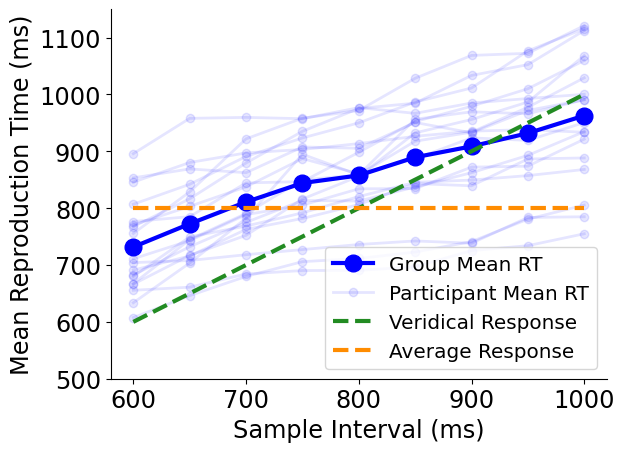

In [ ]:
fig, ax = plt.subplots()

group_mean = []

for SI in SIs:
  group_mean.append(mean_RTs["Mean_RT"][mean_RTs["SI"] == SI].mean())

ax.plot(SIs, group_mean, color = "b", marker = "o", markersize = 12, linewidth = 3, label = "Group Mean RT")
for ID in ID_list:
  participant_df = mean_RTs[mean_RTs["ID"] == ID]
  if ID == ID_list[0]:
    ax.plot(SIs, participant_df["Mean_RT"], color = "b", marker = "o", linewidth = 2, alpha = 0.1, label = "Participant Mean RT")
  else:
    ax.plot(SIs, participant_df["Mean_RT"], color = "b", marker = "o", linewidth = 2, alpha = 0.1)

sns.despine()
plt.ylabel("Mean RT (ms)")
plt.ylim(500, 1150)

plt.plot(SIs, SIs, "--", color = "forestgreen", linewidth = 3, label = "Veridical Response")
plt.plot(SIs, np.mean(SIs) + np.zeros(len(SIs)), color = "darkorange", linestyle = "--", linewidth = 3, label = "Average Response")
print(np.mean(SIs) + np.zeros(len(SIs)))

plt.xlabel("Sample Interval (ms)", fontsize = "xx-large")
plt.ylabel("Mean Reproduction Time (ms)", fontsize = "xx-large")
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")
plt.legend(fontsize = "x-large")

fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/Behaviour/" + "Mean_Reproduction_Time.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

### Calculate Linear Regression for each participant

Text(0, 0.5, 'Beta Value for Sample Interval')

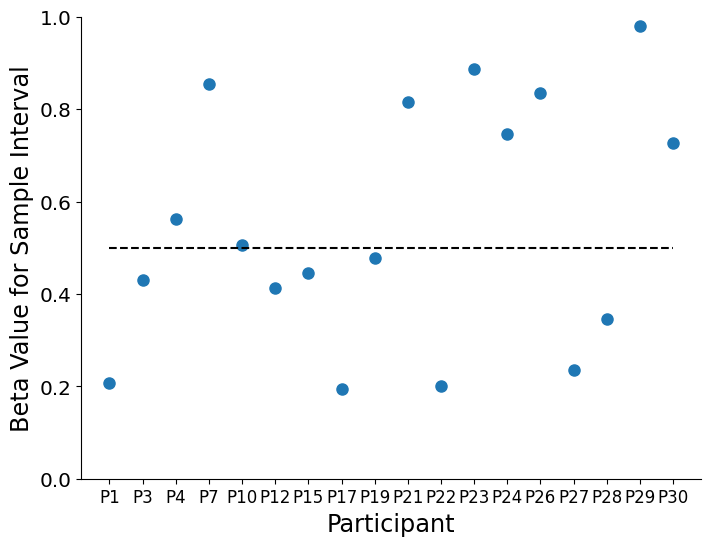

In [ ]:
weights = np.zeros(len(ID_list))
intercepts = np.zeros(len(ID_list))
r_squareds = np.zeros(len(ID_list))
pvalues = np.zeros(len(ID_list))

for i in range(0, len(ID_list)):
  participant_df = group_behaviour_df[group_behaviour_df["ID"] == ID_list[i]]
  result = stats.linregress(participant_df["SI"], participant_df["Response_Time"])
  weights[i] = result.slope
  intercepts[i] = result.intercept
  r_squareds[i] = result.rvalue ** 2
  pvalues[i] = result.pvalue

## Plot ##
fig, ax = plt.subplots(figsize = (8, 6))

sns.despine()

plt.plot(ID_list, weights, "o", markersize = "8")
plt.plot(ID_list, np.ones(len(ID_list)) / 2, "k--")
plt.ylim(0, 1)
plt.xlabel("Participant", fontsize = "xx-large")
ax.tick_params(axis = "y", labelsize = "x-large")
ax.tick_params(axis = "x", labelsize = "large")
plt.ylabel("Beta Value for Sample Interval", fontsize = "xx-large")

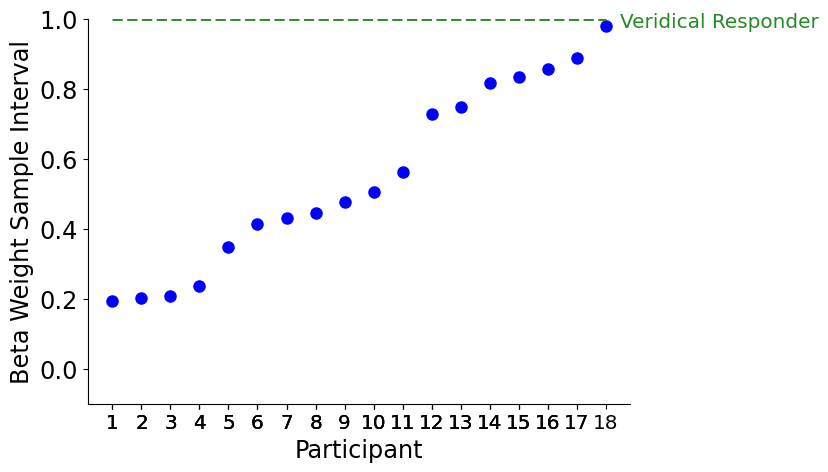

In [ ]:
fig, ax = plt.subplots(figsize = (7, 5))

plt.plot(np.arange(1, len(ID_list) + 1), np.sort(weights), "bo", markersize = "8")
plt.plot(np.arange(1, len(ID_list) + 1), np.ones(len(ID_list)), "--", color = "forestgreen", linewidth = 2)
#plt.plot(np.arange(1, len(ID_list) + 1), np.zeros(len(ID_list)), "--", color = "darkorange", linewidth = 2)

ax.text(x = 18.5, y = 0.975, s = "Veridical Responder", fontsize = "x-large", color = "forestgreen")
#ax.text(x = 18.5, y = -0.025, s = "Average Responder", fontsize = "x-large", color = "darkorange")

sns.despine()
plt.ylim(-0.1, 1)
plt.xlabel("Participant", fontsize = "xx-large")
plt.xticks(np.linspace(1, 18, dtype = int))
ax.tick_params(axis = "y", labelsize = "xx-large")
ax.tick_params(axis = "x", labelsize = "x-large")
plt.ylabel("Beta Weight Sample Interval", fontsize = "xx-large")

fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/Behaviour/" + "SI_Beta_Weights.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

# Relationship between gap and RT

## Z-Score gap duration within participant and then plot as a group

In [ ]:
standardized_gaps = list(np.zeros(len(ID_list)))

for i in range(0, len(ID_list)):
  ID = ID_list[i]
  participant_df = group_behaviour_df.query("ID == @ID")
  standardized_gaps[i] = np.array((participant_df["Gap"] - np.nanmean(participant_df["Gap"])) / np.nanstd(participant_df["Gap"]))

group_behaviour_df["Gap"] = np.concatenate(standardized_gaps)

## Break up into gap bins for each participant and get mean RT for each bin

In [ ]:
mean_RT = np.zeros((len(ID_list), 3))
mean_gap_bins = np.zeros((len(ID_list), 3))

for i in range(0, len(ID_list)): # iterate through participants
  ID = ID_list[i]
  gap_cutoff_1 = 0
  gap_cutoff_2 = 0
  participant_df = group_behaviour_df.query("ID == @ID").copy()
  sorted_gap = np.sort(participant_df["Gap"])
  cutoff_1 = int(len(sorted_gap) / 3)
  cutoff_2 = int(cutoff_1 * 2)
  gap_cutoff_1 = sorted_gap[cutoff_1]
  gap_cutoff_2 = sorted_gap[cutoff_2]

  ## Tag Each trial as an RT bin ##
  index = participant_df.index
  for ind in range(0, participant_df.shape[0]):
    if participant_df.at[index[ind], "Gap"] < gap_cutoff_1:
      participant_df.at[index[ind], "Gap_Bin"] = 1
    elif participant_df.at[index[ind], "Gap"] > gap_cutoff_2:
      participant_df.at[index[ind], "Gap_Bin"] = 3
    else:
      participant_df.at[index[ind], "Gap_Bin"] = 2

  ## Calculate mean RT and CNV slope for each bin ##
  for k in range(1, 4): # iterate through RT bins
    mean_RT[i, k - 1] = np.nanmean(participant_df["Response_Time"][participant_df["Gap_Bin"] == k])
    mean_gap_bins[i, k - 1] = np.nanmean(participant_df["Gap"][participant_df["Gap_Bin"] == k])

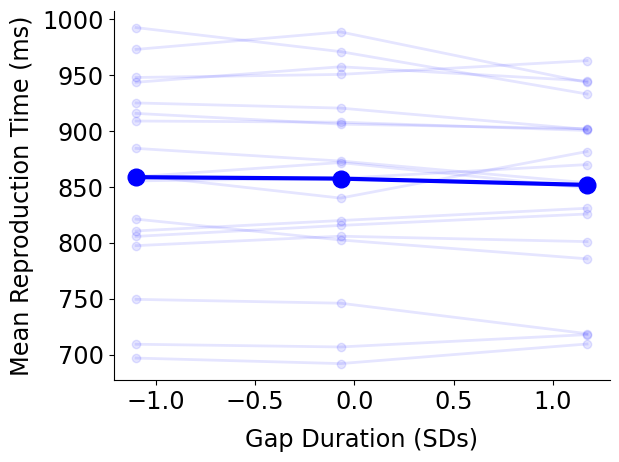

In [ ]:
plt.plot(np.mean(mean_gap_bins, axis = 0), np.mean(mean_RT, axis = 0), color = "blue", marker = "o", markersize = 12, linewidth = 3, label = "Group Mean RT")

for i in range(0, len(ID_list)):
  if i == 0:
    plt.plot(np.mean(mean_gap_bins, axis = 0), mean_RT[i], color = "blue", marker = "o", linewidth = 2, alpha = 0.1, label = "Participant Mean RT")
  else:
    plt.plot(np.mean(mean_gap_bins, axis = 0), mean_RT[i], color = "blue", marker = "o", linewidth = 2, alpha = 0.1)

plt.xlabel("Gap Duration (SDs)", fontsize = "xx-large", labelpad = 10)
plt.ylabel("Mean Reproduction Time (ms)", fontsize = "xx-large", labelpad = 6)
#plt.xlim(700, 1100)
ax = plt.gca()
sns.despine()
ax.tick_params(labelsize = "xx-large")
#plt.legend(fontsize = "x-large")

fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/Behaviour/" + "Rreproduction_Time_Gap_Bins.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

In [ ]:
print(np.mean(mean_RT, axis = 0)[-1] - np.mean(mean_RT, axis = 0)[0])
print(np.mean(mean_RT, axis = 0))

-6.936949788702577
[858.80207457 857.50252427 851.86512478]


# Does sample interval on the previous trial effect RT on the current trial?
Ideally here then the metadata needs to tell us what block the participant is on so we can remove the first trial of each block

## Create p_SI (previous SI) column

In [ ]:
group_behaviour_df["p_SI"] = np.zeros(group_behaviour_df.shape[0])

for i in range(0, len(ID_list)):
  participant_df = group_behaviour_df[group_behaviour_df["ID"] == ID_list[i]] # get data for one participant
  previous_trial_SI = np.zeros(participant_df.shape[0])
  previous_trial_SI[0] = np.NaN # setting first value to NaN
  previous_trial_SI[1:] = participant_df["SI"][0:-1]
  group_behaviour_df["p_SI"][group_behaviour_df["ID"] == ID_list[i]] = previous_trial_SI

<ipython-input-34-0c399ca7dc9e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_behaviour_df["p_SI"][group_behaviour_df["ID"] == ID_list[i]] = np.array(previous_trial_SI)
<ipython-input-34-0c399ca7dc9e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_behaviour_df["p_SI"][group_behaviour_df["ID"] == ID_list[i]] = np.array(previous_trial_SI)
<ipython-input-34-0c399ca7dc9e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr

In [ ]:
group_behaviour_df.head()

,ID,Response_Time,Over_Under,Mean_RT,Median_RT,SI,Gap,Reject_Artif,RT_gap,Reject_All,p_SI
0,P1,801.562500,0.0,1026.308594,1013.867188,850,-0.003849,0.0,1283.203125,0.0,NaN
1,P1,815.234375,0.0,997.128906,981.640625,700,-0.645328,0.0,1267.578125,1.0,850.0
2,P1,811.328125,0.0,1035.390625,1028.515625,900,-0.559797,1.0,1267.578125,1.0,700.0
3,P1,811.328125,0.0,1038.046875,1029.492188,950,-1.286807,0.0,1234.375000,1.0,900.0
4,P1,864.062500,0.0,1013.515625,1011.914062,800,0.124447,0.0,1351.562500,0.0,950.0


## Get conditions
Within participant, get mean or median RT for each sample interval

In [ ]:
SIs = np.unique(group_behaviour_df["SI"])
n_bins = len(SIs)
p_mean_RTs = pd.DataFrame({"ID": list("0") * (len(ID_list) * n_bins),
                         "p_SI": np.zeros(len(ID_list) * n_bins),
                          "Mean_RT": np.zeros(len(ID_list) * n_bins),
                           "Median_RT": np.zeros(len(ID_list) * n_bins)})

i  = -1

for ID in ID_list:
  participant_df = group_behaviour_df[group_behaviour_df["ID"] == ID]

  for j in range(0, n_bins):
    i += 1
    p_mean_RTs.at[i, "ID"] = ID
    p_mean_RTs.at[i, "p_SI"] = SIs[j]
    p_mean_RTs.at[i, "Mean_RT"] = participant_df["Response_Time"][participant_df["p_SI"] ==  SIs[j]].mean()
    p_mean_RTs.at[i, "Median_RT"] = participant_df["Response_Time"][participant_df["p_SI"] ==  SIs[j]].median()

In [ ]:
p_mean_RTs

,ID,p_SI,Mean_RT,Median_RT
0,P1,600.0,901.679688,893.359375
1,P1,650.0,922.617188,908.984375
2,P1,700.0,913.867188,914.843750
3,P1,750.0,924.589844,917.773438
4,P1,800.0,902.079388,897.265625
...,...,...,...,...
157,P30,800.0,904.940025,914.843750
158,P30,850.0,897.226562,869.921875
159,P30,900.0,890.044981,875.781250
160,P30,950.0,901.425781,904.101562


## Plot

[800. 800. 800. 800. 800. 800. 800. 800. 800.]


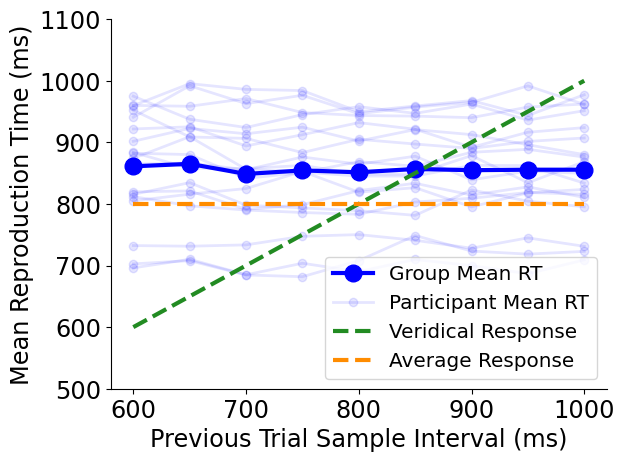

In [ ]:
fig, ax = plt.subplots()

group_mean = []

for SI in SIs:
  group_mean.append(p_mean_RTs["Mean_RT"][p_mean_RTs["p_SI"] == SI].mean())

ax.plot(SIs, group_mean, color = "b", marker = "o", markersize = 12, linewidth = 3, label = "Group Mean RT")
for ID in ID_list:
  participant_df = p_mean_RTs[p_mean_RTs["ID"] == ID]
  if ID == ID_list[0]:
    ax.plot(SIs, participant_df["Mean_RT"], color = "b", marker = "o", linewidth = 2, alpha = 0.1, label = "Participant Mean RT")
  else:
    ax.plot(SIs, participant_df["Mean_RT"], color = "b", marker = "o", linewidth = 2, alpha = 0.1)

sns.despine()
plt.ylabel("Mean RT (ms)")
plt.ylim(500, 1100)

plt.plot(SIs, SIs, "--", color = "forestgreen", linewidth = 3, label = "Veridical Response")
plt.plot(SIs, np.mean(SIs) + np.zeros(len(SIs)), color = "darkorange", linestyle = "--", linewidth = 3, label = "Average Response")

plt.xlabel("Previous Trial Sample Interval (ms)", fontsize = "xx-large")
plt.ylabel("Mean Reproduction Time (ms)", fontsize = "xx-large")
print(np.mean(SIs) + np.zeros(len(SIs)))
ax = plt.gca()
ax.tick_params(labelsize = "xx-large")
plt.legend(fontsize = "x-large")

fname = "/content/gdrive/MyDrive/Time_Reproduction/Plots/Behaviour/" + "Mean_Reproduction_Time_p_SI.png"
plt.savefig(fname, dpi = 300, bbox_inches = "tight")

# Standardize SI Variable and save files for JASP

In [ ]:
SIz = (np.array(SIs) - np.mean(SIs)) / np.std(SIs)

[-1.54919334 -1.161895   -0.77459667 -0.38729833  0.          0.38729833
  0.77459667  1.161895    1.54919334]


In [ ]:
replace_dict = {600: SIz[0], 650: SIz[1], 700: SIz[2], 750: SIz[3], 800:SIz[4], 850:SIz[5], 900:SIz[6], 950:SIz[7], 1000:SIz[8]}
group_behaviour_df["SI"].replace(replace_dict, inplace = True)

In [ ]:
group_behaviour_df["Response_Time"] = (group_behaviour_df["Response_Time"] - group_behaviour_df["Response_Time"].mean()) / group_behaviour_df["Response_Time"].std()

In [ ]:
fname = "/content/gdrive/MyDrive/Time_Reproduction/JASP_Files_TR/" + "behaviour_TR.csv"
group_behaviour_df.to_csv(fname)